# Intro



[Neural Network Intro](https://www.youtube.com/watch?v=bfmFfD2RIcg)

[Medmnist](https://medmnist.com/)

[NN Visualizer](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.66910&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

# Setup

**Change Your Runtime Type**


1.   Click "runtime" in the top toolbar
2.   Choose "change runtime type"
3.   Choose "GPU" from the dropdown
4.   Click "save"




**Install and Import Necessary Libraries**

In [ ]:
!pip install --upgrade git+https://github.com/MedMNIST/MedMNIST.git --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
from tqdm import tqdm
%matplotlib inline

**Pick a Dataset**

Run the below code block to print out the datasets that should work with this script. Choose one from the list, and set "data_flag" in the next block equal to the dataset name (for example, for the pathmnist dataset, you would use data_flag = 'pathmnist'). Be aware that larger datasets will lead to longer training times

In [ ]:
for (flag, info) in INFO.items():
  if ('3d' not in flag) and ('class' in info['task']) and (info['task'] != "multi-label, binary-class"):
    print('{}, {} images'.format(flag, info['n_samples']['train']))


pathmnist, 89996 images
dermamnist, 7007 images
octmnist, 97477 images
pneumoniamnist, 4708 images
breastmnist, 546 images
bloodmnist, 11959 images
tissuemnist, 165466 images
organamnist, 34581 images
organcmnist, 13000 images
organsmnist, 13940 images


In [ ]:
data_flag = 'octmnist'

**Gather Information on Your Chosen Dataset**

Run the below block of code to print a summary of your dataset, and store some of the values for use later

In [ ]:
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_images = sum([info['n_samples'][split] for split in ['train', 'test', 'val']])

print('chosen dataset: ' + data_flag)
print('image type: ' + 'grayscale' if n_channels == 1 else 'RGB')
print('GPU enabled: ' + str(torch.cuda.is_available()))
print('n images: ' + str(n_images))
print('train/val/test split: {}/{}/{}'.format(*[info['n_samples'][split]/n_images for split in ['train', 'test', 'val']]))
print('task: ' + info['task'])
print('labels: ' + str(info['label']))
print('description: ' + info['description'])

chosen dataset: octmnist
image type: grayscale
GPU enabled: True
n images: 109309
train/val/test split: 0.8917563970029915/0.009148377535244124/0.09909522546176436
task: multi-class
labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.


**Download Dataset and Set up Data Loaders**

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=True)
val_dataset = DataClass(split='test', transform=data_transform, download=True)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*128, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*128, shuffle=False)

dataloader_dict = {'train': train_loader, 'val': val_loader}

100%|██████████| 54938180/54938180 [00:03<00:00, 16867297.85it/s]


Using downloaded and verified file: /root/.medmnist/octmnist.npz


**Take a Look at the Images You'll be Using**

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


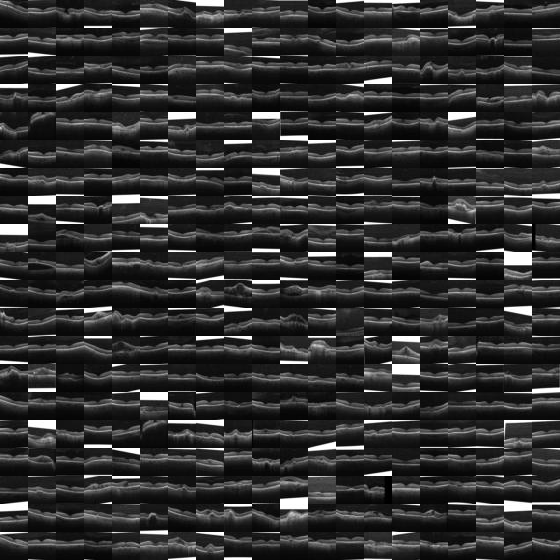

In [ ]:
train_dataset.montage(length=20)

**Define a Simple Convolutional Neural Network**

Run the below block of code to create a class representing a simple convolutional neural network. Convolutional Neural Networks (CNN's) are frequently used when analyzing images. They excel at learning to detect features (qualities of the input data that are broadly useful for performing the desired task) in images. In shallow neural networks (like the one we'll build today), features might correspond to simple geometric elements or particular colors. As the depth of the network increases, so to does the complexity of the features it can detect. See [this link](https://distill.pub/2017/feature-visualization/) for an interesting article on how we can visualize features in deep CNN's.

In [ ]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



**Create a Function to Train your Model**

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    labels = labels.squeeze().long()
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            elif phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    hist = {'train_acc': train_acc_history, 'train_loss': train_loss_history,
            'val_acc': val_acc_history, 'val_loss': val_loss_history}
    return model, hist

**Set Training Parameters**

In [ ]:
lr = 0.001
num_epochs = 30
momentum = 0.9

**Instantiate the Model, Create and Optimizer, and Appropriate Loss Criterion**

In [ ]:
model = Net(in_channels=n_channels, num_classes=n_classes).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

criterion = nn.CrossEntropyLoss()

**Train your Model**

In [ ]:
model, hist = train_model(model, dataloader_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/29
----------


100%|██████████| 762/762 [00:34<00:00, 22.10it/s]


train Loss: 0.6979 Acc: 0.7466



100%|██████████| 4/4 [00:00<00:00, 17.51it/s]


val Loss: 0.9374 Acc: 0.6140


Epoch 1/29
----------


100%|██████████| 762/762 [00:26<00:00, 28.98it/s]


train Loss: 0.4522 Acc: 0.8435



100%|██████████| 4/4 [00:00<00:00, 19.27it/s]


val Loss: 0.8173 Acc: 0.6860


Epoch 2/29
----------


100%|██████████| 762/762 [00:29<00:00, 25.65it/s]


train Loss: 0.3853 Acc: 0.8664



100%|██████████| 4/4 [00:00<00:00, 19.03it/s]


val Loss: 0.8222 Acc: 0.6800


Epoch 3/29
----------


100%|██████████| 762/762 [00:26<00:00, 29.07it/s]


train Loss: 0.3437 Acc: 0.8802



100%|██████████| 4/4 [00:00<00:00, 19.24it/s]


val Loss: 0.9271 Acc: 0.7130


Epoch 4/29
----------


100%|██████████| 762/762 [00:26<00:00, 29.09it/s]


train Loss: 0.3157 Acc: 0.8910



100%|██████████| 4/4 [00:00<00:00, 19.51it/s]


val Loss: 0.5983 Acc: 0.7650


Epoch 5/29
----------


100%|██████████| 762/762 [00:26<00:00, 28.48it/s]


train Loss: 0.2911 Acc: 0.8995



100%|██████████| 4/4 [00:00<00:00, 18.81it/s]


val Loss: 0.7221 Acc: 0.7360


Epoch 6/29
----------


100%|██████████| 762/762 [00:25<00:00, 29.70it/s]


train Loss: 0.2711 Acc: 0.9064



100%|██████████| 4/4 [00:00<00:00, 14.26it/s]


val Loss: 0.9000 Acc: 0.6810


Epoch 7/29
----------


100%|██████████| 762/762 [00:25<00:00, 30.17it/s]


train Loss: 0.2528 Acc: 0.9126



100%|██████████| 4/4 [00:00<00:00, 14.30it/s]


val Loss: 0.8092 Acc: 0.6990


Epoch 8/29
----------


100%|██████████| 762/762 [00:25<00:00, 29.91it/s]


train Loss: 0.2378 Acc: 0.9169



100%|██████████| 4/4 [00:00<00:00, 20.89it/s]


val Loss: 0.8338 Acc: 0.7050


Epoch 9/29
----------


100%|██████████| 762/762 [00:25<00:00, 29.42it/s]


train Loss: 0.2207 Acc: 0.9228



100%|██████████| 4/4 [00:00<00:00, 18.99it/s]


val Loss: 0.9715 Acc: 0.7070


Epoch 10/29
----------


100%|██████████| 762/762 [00:26<00:00, 29.30it/s]


train Loss: 0.2046 Acc: 0.9290



100%|██████████| 4/4 [00:00<00:00, 20.03it/s]


val Loss: 0.8496 Acc: 0.7110


Epoch 11/29
----------


100%|██████████| 762/762 [00:26<00:00, 29.18it/s]


train Loss: 0.1935 Acc: 0.9329



100%|██████████| 4/4 [00:00<00:00, 20.75it/s]


val Loss: 0.9492 Acc: 0.7020


Epoch 12/29
----------


100%|██████████| 762/762 [00:26<00:00, 29.05it/s]


train Loss: 0.1813 Acc: 0.9370



100%|██████████| 4/4 [00:00<00:00, 19.03it/s]


val Loss: 0.8272 Acc: 0.7290


Epoch 13/29
----------


100%|██████████| 762/762 [00:25<00:00, 29.60it/s]


train Loss: 0.1704 Acc: 0.9409



100%|██████████| 4/4 [00:00<00:00, 19.40it/s]


val Loss: 0.9894 Acc: 0.7290


Epoch 14/29
----------


100%|██████████| 762/762 [00:25<00:00, 29.68it/s]


train Loss: 0.1591 Acc: 0.9443



100%|██████████| 4/4 [00:00<00:00, 13.00it/s]


val Loss: 0.8594 Acc: 0.7310


Epoch 15/29
----------


100%|██████████| 762/762 [00:25<00:00, 30.12it/s]


train Loss: 0.1508 Acc: 0.9471



100%|██████████| 4/4 [00:00<00:00, 14.36it/s]


val Loss: 1.0035 Acc: 0.7370


Epoch 16/29
----------


100%|██████████| 762/762 [00:25<00:00, 29.91it/s]


train Loss: 0.1385 Acc: 0.9520



100%|██████████| 4/4 [00:00<00:00, 19.58it/s]


val Loss: 0.9326 Acc: 0.7350


Epoch 17/29
----------


100%|██████████| 762/762 [00:25<00:00, 29.58it/s]


train Loss: 0.1303 Acc: 0.9556



100%|██████████| 4/4 [00:00<00:00, 19.47it/s]


val Loss: 1.1245 Acc: 0.7200


Epoch 18/29
----------


100%|██████████| 762/762 [00:26<00:00, 29.25it/s]


train Loss: 0.1208 Acc: 0.9583



100%|██████████| 4/4 [00:00<00:00, 20.35it/s]


val Loss: 0.9185 Acc: 0.7300


Epoch 19/29
----------


100%|██████████| 762/762 [00:25<00:00, 29.67it/s]


train Loss: 0.1143 Acc: 0.9603



100%|██████████| 4/4 [00:00<00:00, 20.44it/s]


val Loss: 1.0276 Acc: 0.7340


Epoch 20/29
----------


100%|██████████| 762/762 [00:25<00:00, 29.56it/s]


train Loss: 0.1062 Acc: 0.9628



100%|██████████| 4/4 [00:00<00:00, 19.94it/s]


val Loss: 1.3449 Acc: 0.6860


Epoch 21/29
----------


100%|██████████| 762/762 [00:25<00:00, 29.72it/s]


train Loss: 0.0980 Acc: 0.9664



100%|██████████| 4/4 [00:00<00:00, 20.16it/s]


val Loss: 1.0236 Acc: 0.7500


Epoch 22/29
----------


100%|██████████| 762/762 [00:25<00:00, 29.59it/s]


train Loss: 0.0928 Acc: 0.9680



100%|██████████| 4/4 [00:00<00:00, 13.83it/s]


val Loss: 0.9847 Acc: 0.7390


Epoch 23/29
----------


100%|██████████| 762/762 [00:24<00:00, 31.27it/s]


train Loss: 0.0886 Acc: 0.9689



100%|██████████| 4/4 [00:00<00:00, 15.06it/s]


val Loss: 1.2300 Acc: 0.7250


Epoch 24/29
----------


100%|██████████| 762/762 [00:24<00:00, 30.68it/s]


train Loss: 0.0802 Acc: 0.9727



100%|██████████| 4/4 [00:00<00:00, 20.69it/s]


val Loss: 1.2626 Acc: 0.7160


Epoch 25/29
----------


100%|██████████| 762/762 [00:24<00:00, 30.52it/s]


train Loss: 0.0810 Acc: 0.9719



100%|██████████| 4/4 [00:00<00:00, 21.26it/s]


val Loss: 1.4235 Acc: 0.6940


Epoch 26/29
----------


100%|██████████| 762/762 [00:24<00:00, 31.66it/s]


train Loss: 0.0753 Acc: 0.9735



100%|██████████| 4/4 [00:00<00:00, 20.00it/s]


val Loss: 1.1255 Acc: 0.7410


Epoch 27/29
----------


100%|██████████| 762/762 [00:24<00:00, 31.59it/s]


train Loss: 0.0689 Acc: 0.9757



100%|██████████| 4/4 [00:00<00:00, 22.32it/s]


val Loss: 1.5766 Acc: 0.6840


Epoch 28/29
----------


100%|██████████| 762/762 [00:24<00:00, 31.33it/s]


train Loss: 0.0640 Acc: 0.9775



100%|██████████| 4/4 [00:00<00:00, 20.75it/s]


val Loss: 1.4467 Acc: 0.7210


Epoch 29/29
----------


100%|██████████| 762/762 [00:23<00:00, 31.78it/s]


train Loss: 0.0648 Acc: 0.9776



100%|██████████| 4/4 [00:00<00:00, 21.58it/s]

val Loss: 1.2580 Acc: 0.7370


Training complete in 13m 5s
Best val Acc: 0.765000


**Visualize Training Metrics**

TypeError: ignored

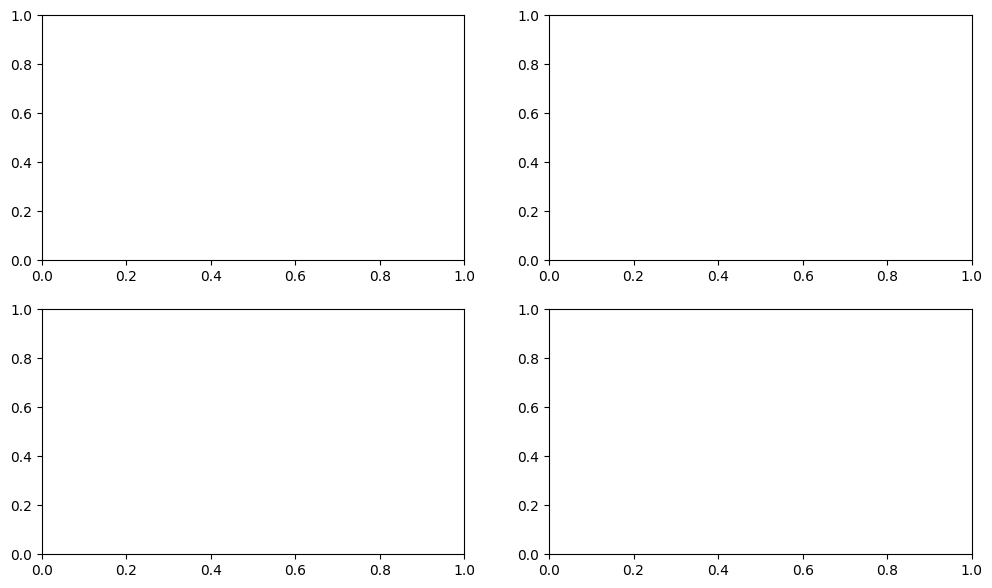

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 7))
ax[0, 0].plot(hist['train_acc'])
ax[0, 0].set(title='Training accuracy', xlabel='epoch', ylabel='training accuracy')
ax[0, 1].plot(hist['train_loss'])
ax[0, 1].set(title='Training loss', xlabel='epoch', ylabel='training loss')
ax[1, 0].plot(hist['val_acc'])
ax[1, 0].set(title='Validation accuracy', xlabel='epoch', ylabel='validation accuracy')
ax[1, 1].plot(hist['val_loss'])
ax[1, 1].set(title='Validation loss', xlabel='epoch', ylabel='validation loss')
fig.tight_layout()

**Run Inference Using Your Trained Network**

The following block of code will select a random image from the validation dataset, use your trained network to predict the label, and compare the predicted label to the actual label. Each time you run this block it will pick a new image.

In [ ]:
ims, labels = next(iter(val_loader))
rand_idx = [np.random.randint(256)]
im = ims[rand_idx][[0]]
model = model.eval()
outputs = model(im.to(device))
_, pred = torch.max(outputs, 1)
conf = torch.softmax(outputs, 1)[0][int(pred)]
im = np.transpose(im[0].cpu().detach().numpy(), (1, 2, 0)).squeeze()
label = labels[rand_idx][0]
plt.imshow(im, cmap='gray')
print('predicted label: ' + info['label'][str(int(pred))])
print('prediction confidence: ' + str(float(conf)))
print('actual label: ' + info['label'][str(int(label))])
print('correct?: ' + str(int(pred) == int(label)))